# Set up OM2 wind forcing file with CM2 bias 

This notebook creates the forcing files that are used for the [H1 hypothesis](https://github.com/willaguiar/DSW-collaborative-project): test if the katabatic winds on JRA55 are the reason for DSW formation in OM2-01 by creating some RYF runs forced with the atmsphere from the coupled model CM2.

This notebook follows the approach of the [easterlies perturation experiment](https://github.com/adele157/easterlies-collaborative-project/blob/master/notebooks/forcing_perturbation/JRA_wind_perturbation_setup.ipynb) to adapt the forcing file.

The notebook follows the following steps:
1) Create monthly climatology of CM2 winds.
2) Interpolate CM2 winds onto JRA forcing file grid.
3) Add CM2 monthly climatology to JRA winds (month by month), then calculate the bias and calculate the rolling mean bias.
4) To change winds near Antarctica only: Create a region mask to separate out the easterlies using the dividing line between the annual average easterly and westerly winds from the JRA55-9091 winds. This is done by selecting a line following the minimum in the absolute value of the annual average wind speed.
5) Create new forcing file with the rolling mean bias of the CM2 winds (south in the regional mask).


In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import shutil as shutil
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45805,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:35977,Total threads: 4
Dashboard: /proxy/33495/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:41295,


In [3]:
fig_path = '/g/data/x77/wgh581/Figures/Figures_DSW_ACCESSOM201/'
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'

## 1) Create CM2 monthly climatology

Import monthly CM2-025 winds

In [4]:
# Data are interpolated onto t-grid
u_CM2 = xr.open_dataarray(path_to_data + 'u_wind_10m_400_499_monthly.nc')
v_CM2 = xr.open_dataarray(path_to_data + 'v_wind_10m_400_499_monthly.nc')

Monthly climatology

In [5]:
u_CM2_month = u_CM2.groupby('time.month').mean('time').load()
v_CM2_month = v_CM2.groupby('time.month').mean('time').load()

# Code below should work, but doesn't reduce the time dimension to 12 months... not sure why
# u_CM2_month = u_CM2.resample(time='M').mean()
# v_CM2_month = v_CM2.resample(time='M').mean()

## 2) Interpolate CM2 winds onto JRA grid

In [6]:
import xesmf as xe

Open the JRA9091 wind files

In [7]:
u_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.u_10.1990_1991.nc'
ds = xr.open_dataset(u_file, decode_times=False)
u = ds.uas_10m
u = u.load()
u_mean = u.mean('time')

v_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.v_10.1990_1991.nc'
ds = xr.open_dataset(v_file, decode_times=False)
v = ds.vas_10m
v = v.load()
v_mean = v.mean('time')

speed_mean = np.sqrt(u_mean**2+v_mean**2)

In [8]:
u_mean = u_mean.load()
v_mean = v_mean.load()
speed_mean = speed_mean.load()

In [9]:
# Rename coordinates (xesmf expects lon, lat)
u_mean = u_mean.rename(({'longitude':'lon', 'latitude':'lat'}))
v_mean = v_mean.rename(({'longitude':'lon', 'latitude':'lat'}))

In [10]:
regridder = xe.Regridder(u_CM2_month, u_mean, method='bilinear', periodic=True)

In [11]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_144x192_320x640_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (144, 192) 
Output grid shape:          (320, 640) 
Periodic in longitude?      True

In [11]:
u_CM2_regridded = regridder(u_CM2_month)

In [12]:
v_CM2_regridded = regridder(v_CM2_month)

## 3) Calculate rolling mean bias

In [13]:
u = u.rename(({'longitude':'lon', 'latitude':'lat'}))
v = v.rename(({'longitude':'lon', 'latitude':'lat'}))

In [14]:
days_per_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]).cumsum()
lat_slice      = slice(-90,-60)
u_difference   = u.copy(deep=True)
v_difference   = v.copy(deep=True)

In [15]:
# # u wind
# for ii in range(len(days_per_month)):
#     if ii == 0:
#         diff_tmp = u_CM2_regridded.sel(lat=lat_slice)[ii] - u.sel(lat=lat_slice)[0:8*days_per_month[ii]]
#         u_difference[0:8*days_per_month[ii],:53,:] =  diff_tmp.transpose("time", "lat", "lon")
#     else:
#         diff_tmp = u_CM2_regridded.sel(lat=lat_slice)[ii] - u.sel(lat=lat_slice)[8*days_per_month[ii-1]:8*days_per_month[ii]]
#         u_difference[8*days_per_month[ii-1]:8*days_per_month[ii],:53,:] =  diff_tmp.transpose("time", "lat", "lon")

# # v wind
# for ii in range(len(days_per_month)):
#     if ii == 0:
#         diff_tmp = v_CM2_regridded.sel(lat=lat_slice)[ii] - v.sel(lat=lat_slice)[0:8*days_per_month[ii]]
#         v_difference[0:8*days_per_month[ii],:53,:] =  diff_tmp.transpose("time", "lat", "lon")
#     else:
#         diff_tmp = v_CM2_regridded.sel(lat=lat_slice)[ii] - v.sel(lat=lat_slice)[8*days_per_month[ii-1]:8*days_per_month[ii]]
#         v_difference[8*days_per_month[ii-1]:8*days_per_month[ii],:53,:] =  diff_tmp.transpose("time", "lat", "lon")

In [19]:
%%time
# u wind
for ii in range(len(days_per_month)):
    if ii == 0:
        diff_tmp = u_CM2_regridded[ii] - u[0:8*days_per_month[ii]]
        u_difference[0:8*days_per_month[ii],:,:] =  diff_tmp.transpose("time", "lat", "lon")
    else:
        diff_tmp = u_CM2_regridded[ii] - u[8*days_per_month[ii-1]:8*days_per_month[ii]]
        u_difference[8*days_per_month[ii-1]:8*days_per_month[ii],:,:] =  diff_tmp.transpose("time", "lat", "lon")

# v wind
for ii in range(len(days_per_month)):
    if ii == 0:
        diff_tmp = v_CM2_regridded[ii] - v[0:8*days_per_month[ii]]
        v_difference[0:8*days_per_month[ii],:,:] =  diff_tmp.transpose("time", "lat", "lon")
    else:
        diff_tmp = v_CM2_regridded[ii] - v[8*days_per_month[ii-1]:8*days_per_month[ii]]
        v_difference[8*days_per_month[ii-1]:8*days_per_month[ii],:,:] =  diff_tmp.transpose("time", "lat", "lon")

CPU times: user 3.62 s, sys: 692 ms, total: 4.31 s
Wall time: 3.9 s


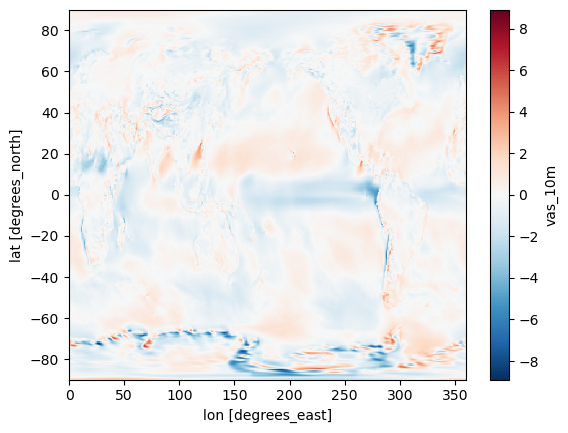

In [21]:
v_difference.mean('time').plot()

Sanity check:

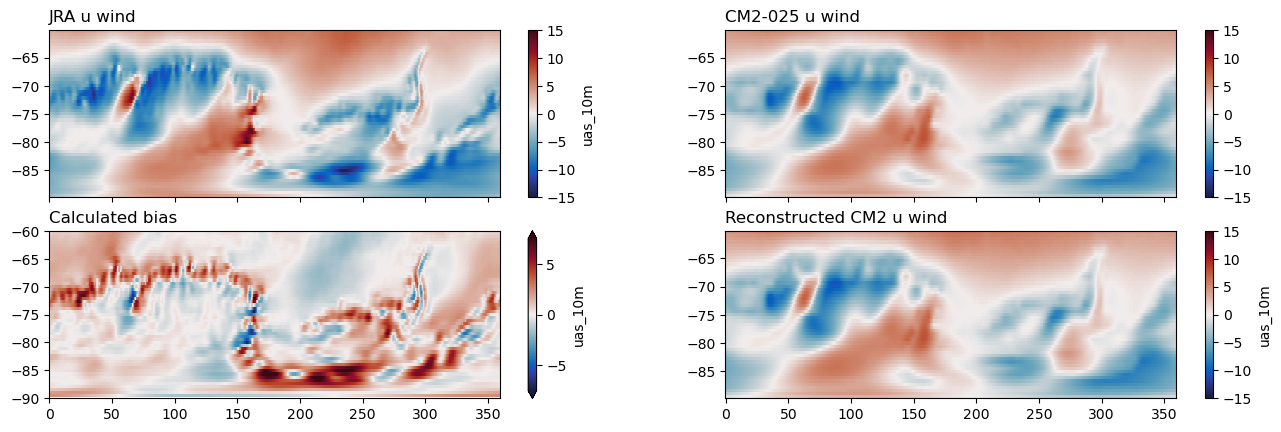

In [17]:
fig = plt.figure(figsize=(16,10))

plt.subplot(421)
u.sel(lat=lat_slice).mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.tick_params(labelbottom=False)
plt.xlabel(''), plt.ylabel(''), plt.title('')
plt.title('JRA u wind', loc='left')

plt.subplot(422)
u_CM2_regridded.sel(lat=lat_slice).mean('month').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.tick_params(labelbottom=False)
plt.xlabel(''), plt.ylabel(''), plt.title('')
plt.title('CM2-025 u wind', loc='left')

plt.subplot(423)
u_difference.mean('time').plot(vmin=-7.5, vmax=7.5, cmap=cmocean.balance)
plt.ylim(-90,-60)
plt.xlabel(''), plt.ylabel(''), plt.title('')
plt.title('Calculated bias', loc='left')

plt.subplot(424)
(u.sel(lat=lat_slice).mean('time') + u_difference.mean('time')).plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.xlabel(''), plt.ylabel(''), plt.title('')
plt.title('Reconstructed CM2 u wind', loc='left');
#(u_CM2_regridded.sel(lat=lat_slice).mean('month') - u.sel(lat=lat_slice).mean('time')).plot(vmin=-7.5, vmax=7.5, cmap=cmocean.balance)
#plt.xlabel(''), plt.ylabel(''), plt.title('')
#plt.title('Difference of means', loc='left');

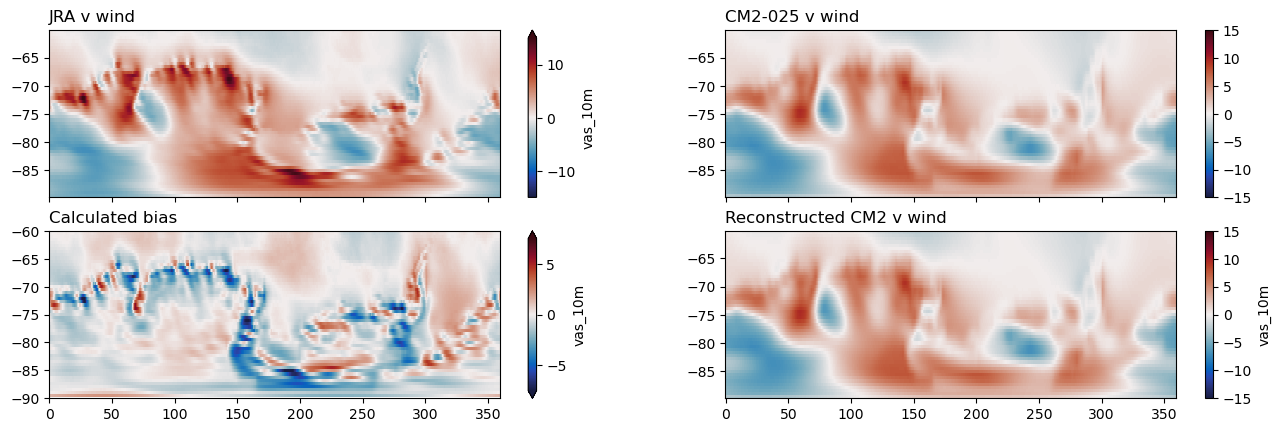

In [18]:
fig = plt.figure(figsize=(16,10))

plt.subplot(421)
v.sel(lat=lat_slice).mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.tick_params(labelbottom=False)
plt.xlabel(''), plt.ylabel(''), plt.title('')
plt.title('JRA v wind', loc='left')

plt.subplot(422)
v_CM2_regridded.sel(lat=lat_slice).mean('month').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.tick_params(labelbottom=False)
plt.xlabel(''), plt.ylabel(''), plt.title('')
plt.title('CM2-025 v wind', loc='left')

plt.subplot(423)
v_difference.mean('time').plot(vmin=-7.5, vmax=7.5, cmap=cmocean.balance)
plt.ylim(-90,-60)
plt.xlabel(''), plt.ylabel(''), plt.title('')
plt.title('Calculated bias', loc='left')

plt.subplot(424)
(v.sel(lat=lat_slice).mean('time') + v_difference.mean('time')).plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.xlabel(''), plt.ylabel(''), plt.title('')
plt.title('Reconstructed CM2 v wind', loc='left');

Now calculate a rolling mean of the bias (to avoid jumps from last day of a month to the first day of a month)

In [22]:
%%time
# first pad start and end of year, so rolling mean wraps around Dec/Jan division:
u_pad = u_difference.pad(time=15*8, mode='wrap') # pad with 15 days of data to allow for monthly averages
v_pad = v_difference.pad(time=15*8, mode='wrap') # pad with 15 days of data to allow for monthly averages

# compute rolling mean using a 30 day window:
u_monthly_mean = u_pad.rolling(time=8*30,center=True).mean().dropna('time')
v_monthly_mean = v_pad.rolling(time=8*30,center=True).mean().dropna('time')

# this somehow ends up with 1 timestep too many, drop last time index to fix:
u_monthly_mean = u_monthly_mean[:-1,...]
v_monthly_mean = v_monthly_mean[:-1,...]

CPU times: user 1min 24s, sys: 2min 6s, total: 3min 31s
Wall time: 3min 10s


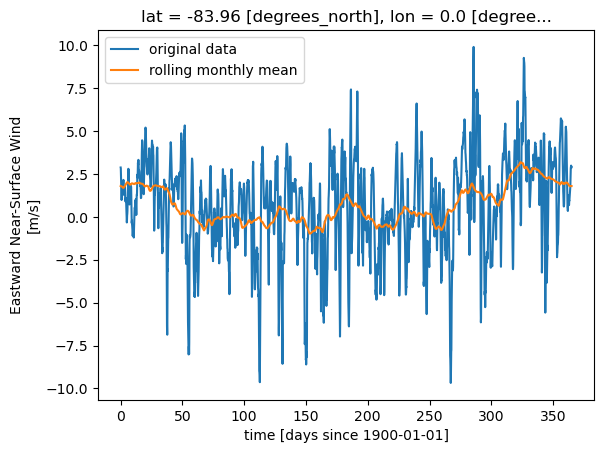

In [23]:
# check it looks sensible for sample location:
u_difference[:,10,0].plot(label='original data')
u_monthly_mean[:,10,0].plot(label='rolling monthly mean')
plt.legend()

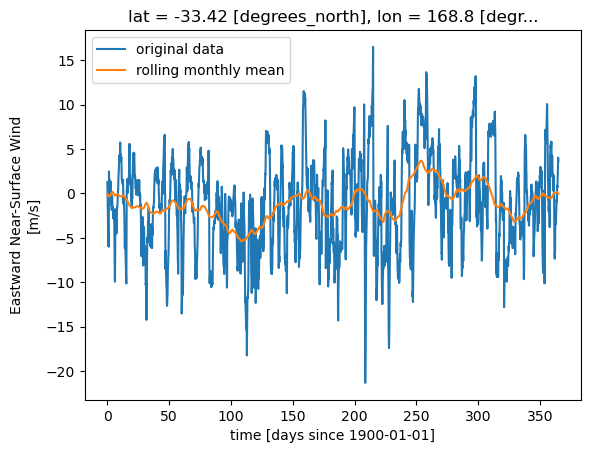

In [25]:
# check it looks sensible for different sample location:
u_difference[:,100,300].plot(label='original data')
u_monthly_mean[:,100,300].plot(label='rolling monthly mean')
plt.legend()

## 4) Create regional mask

Open ocean bathymetry

In [21]:
# open bathymetry and shift to JRA forcing coordinates:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'

ht = cc.querying.getvar(expt,'ht' , session,n=1)
# find index where xt_ocean>=0 to roll coords:
xt_ocean = ht.xt_ocean
shift_index = np.where(xt_ocean>=0)[0][0]
ht = ht.roll(xt_ocean=-shift_index,roll_coords=True)
# make xt_ocean go from 0 to 360:
shift_xt_ocean = ht.xt_ocean
new_xt_ocean = np.where(shift_xt_ocean<0,shift_xt_ocean+360,shift_xt_ocean)
ht.coords['xt_ocean'] = new_xt_ocean

land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

Find easterly/westerly dividing line for annual average:

Note that this is similar for each season, so we'll just use the annual average line to mask all times

In [22]:
# mask peninsula to avoid anomalies there:
peninsula_mask = speed_mean.where(speed_mean.latitude<-68).where(speed_mean.longitude>285).where(speed_mean.longitude<296)*0
peninsula_mask = peninsula_mask.fillna(1)
peninsula_mask = peninsula_mask.where(peninsula_mask==1)

latitude = speed_mean.latitude
longitude = speed_mean.longitude

def find_min_lat(var):
    # mask outside of 60 and 90S:
    speed_mask = var.where(var.latitude<-60).where(var.latitude>-90)

    # first pass at latitude indices where speed is a minimum:
    min_lat_indices = (peninsula_mask*speed_mask).argmin(dim='latitude')

    # remove large latitude jumps in min_lat_indices:
    filtered_min_lat_indices = min_lat_indices.copy()
    for i in range(len(longitude)-1):
        if np.abs(min_lat_indices[i+1] - filtered_min_lat_indices[i]) > 4:
            filtered_min_lat_indices[i+1] = np.maximum(min_lat_indices[i+1],filtered_min_lat_indices[i])

    # and apply a smoothing:
    smoothed_min_lat_indices = np.ceil((filtered_min_lat_indices.roll(longitude=3,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=2,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=1,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=-1,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=-2,roll_coords=False) +
                                    filtered_min_lat_indices.roll(longitude=-3,roll_coords=False) + filtered_min_lat_indices)/7)

    # pick out latitude values:
    smoothed_min_lat = latitude.isel(latitude=smoothed_min_lat_indices.astype(int))
    return smoothed_min_lat

In [23]:
smoothed_min_lat = find_min_lat(speed_mean)

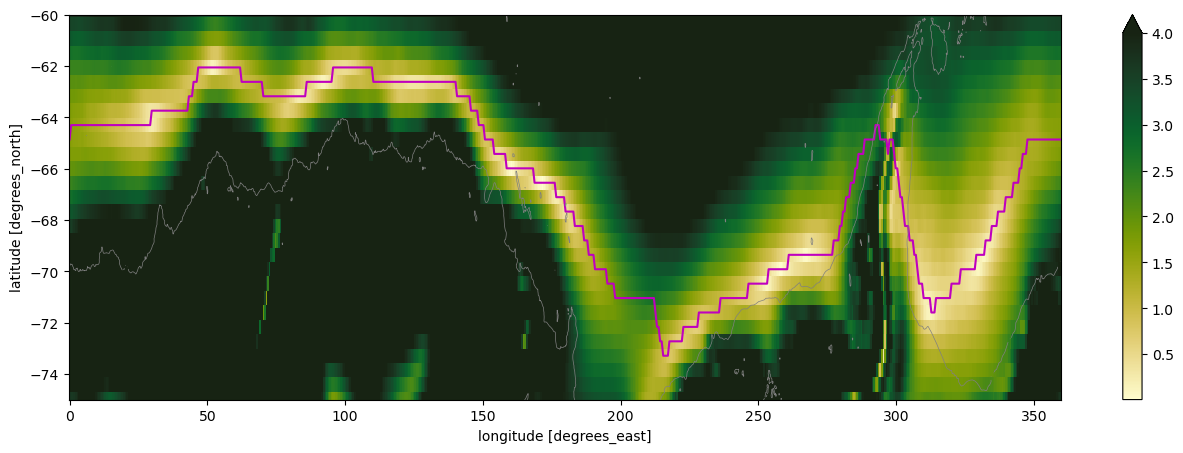

In [24]:
# plot to check:
plt.figure(figsize=(16,5))
speed_mean.plot(cmap=cmocean.speed,vmax=4)
plt.ylim(-75,-60)
plt.plot(longitude,smoothed_min_lat,'m')
# also plot model coastline and 1000m isobath:
plt.contour(ht.xt_ocean, ht.yt_ocean, ht, levels=[1000], linewidths=0.5, colors='grey')
plt.contour(ht.xt_ocean, ht.yt_ocean, land_mask, levels=[0.5], colors='grey')

Create mask based on annual dividing line:

This will be equal to 1 in the south where we want to apply the perturbation and 0 to the north, with smoothing between the 2 regions

In [26]:
wind_mask = speed_mean*0 + 1
wind_mask = wind_mask.where(latitude<smoothed_min_lat)
wind_mask = wind_mask.fillna(0)

# smooth mask:
wind_mask=scipy.ndimage.gaussian_filter(wind_mask, sigma=1)

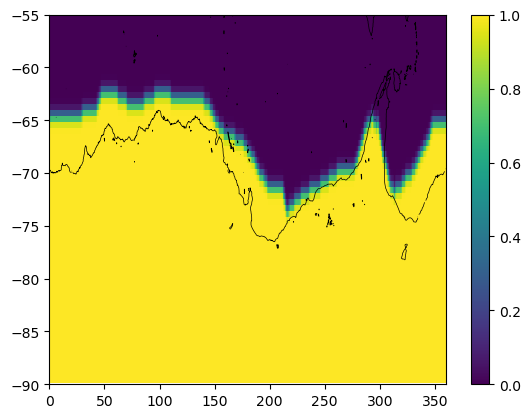

In [27]:
plt.pcolormesh(longitude, latitude, wind_mask)
plt.colorbar()
plt.contour(ht.xt_ocean, ht.yt_ocean, ht, levels=[1000], linewidths=0.5, colors='k')
plt.contour(ht.xt_ocean, ht.yt_ocean, land_mask, levels=[0.5], colors='k')
plt.ylim(-90,-55);

## 5) Create final forcing file 

### 5.1 Add bias to near-Antarctic winds only

In [49]:
u_bias = (u_monthly_mean*wind_mask).load()
v_bias = (v_monthly_mean*wind_mask).load()

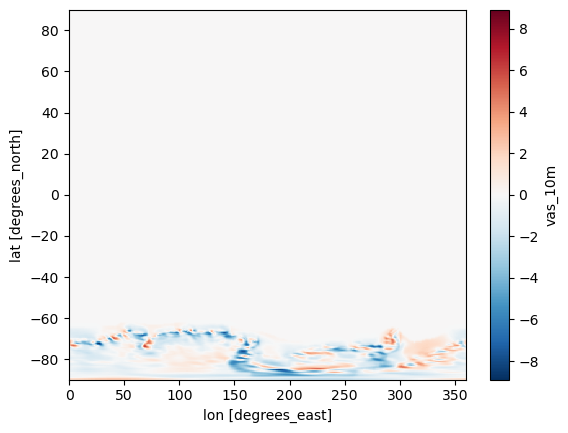

In [34]:
v_bias.mean('time').plot()

In [50]:
u_new = u + u_bias
v_new = v + v_bias

Text(0.5, 1.0, 'CM2 biased forcing file')

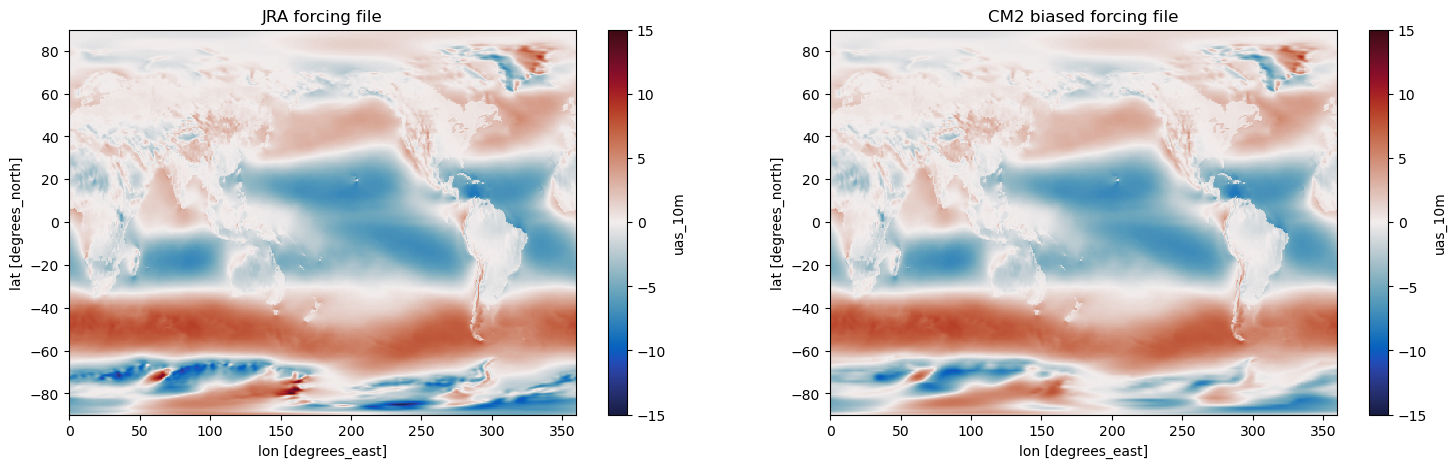

In [55]:
fig = plt.figure(figsize=(18,5))

plt.subplot(121)
u.mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.title('JRA forcing file')

plt.subplot(122)
u_new.mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.title('CM2 biased forcing file')

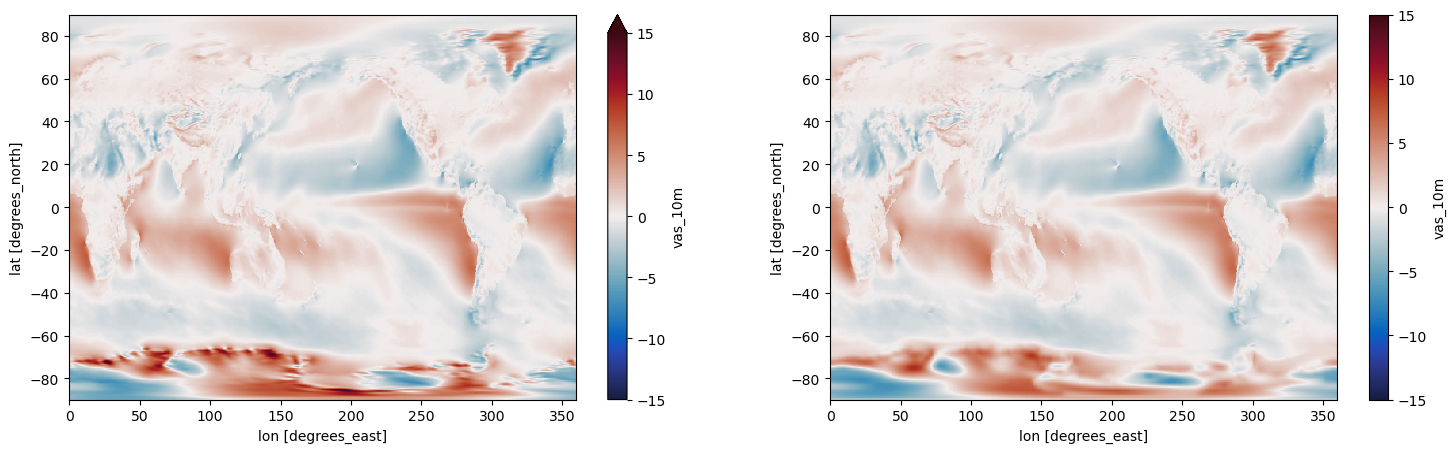

In [54]:
fig = plt.figure(figsize=(18,5))

plt.subplot(121)
v.mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.title('JRA forcing file')

plt.subplot(122)
v_new.mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.title('CM2 biased forcing file')

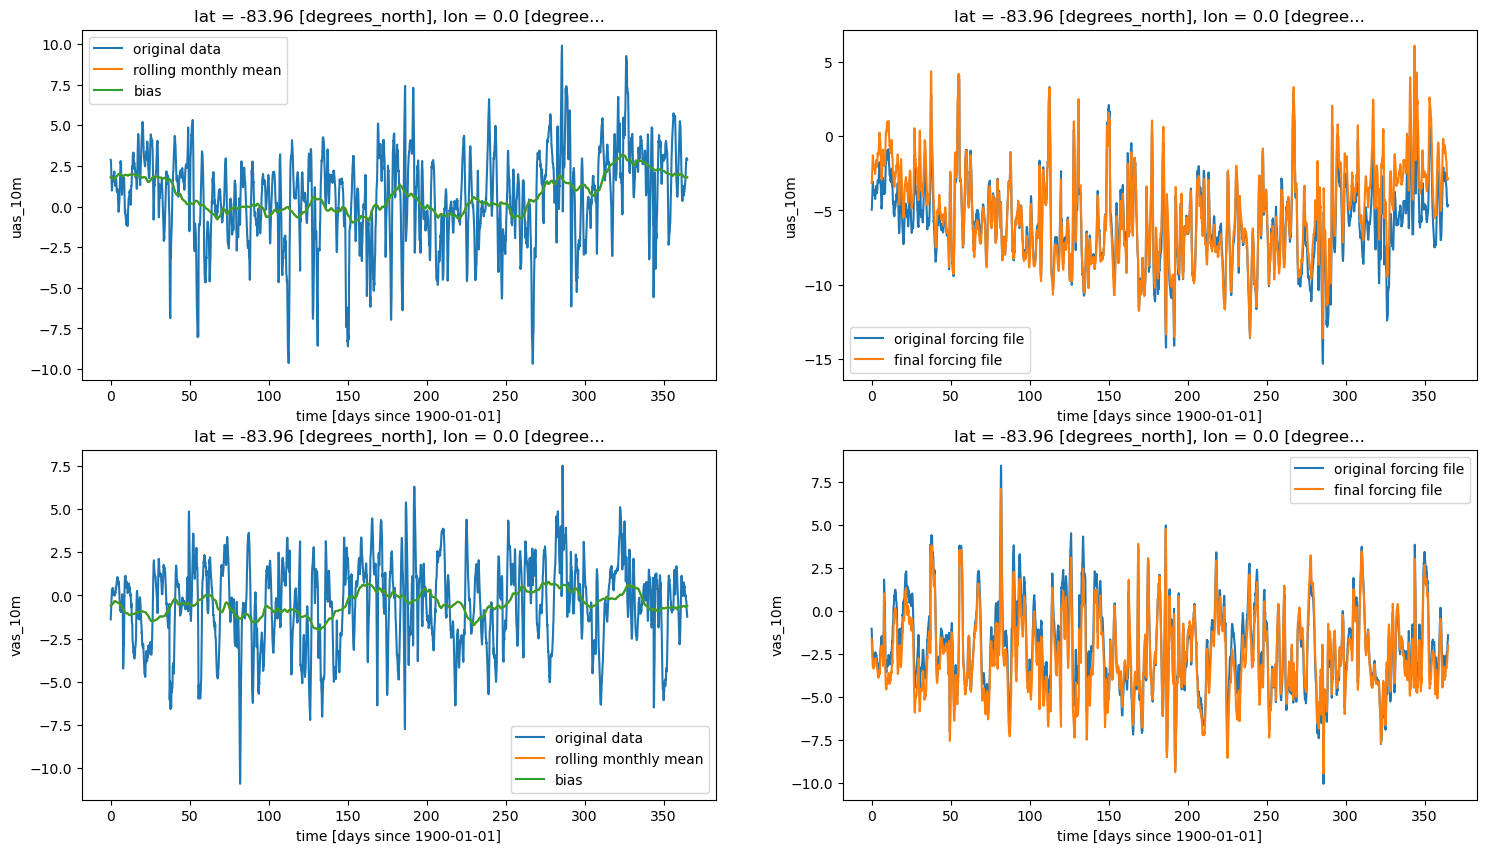

In [52]:
# check it looks sensible for sample location:

fig = plt.figure(figsize=(18,10))

plt.subplot(221)
u_difference[:,10,0].plot(label='original data')
u_monthly_mean[:,10,0].plot(label='rolling monthly mean')
u_bias[:,10,0].plot(label='bias')
plt.legend()

plt.subplot(222)
u[:,10,0].plot(label='original forcing file')
u_new[:,10,0].plot(label='final forcing file')
plt.legend()

plt.subplot(223)
v_difference[:,10,0].plot(label='original data')
v_monthly_mean[:,10,0].plot(label='rolling monthly mean')
v_bias[:,10,0].plot(label='bias')
plt.legend()

plt.subplot(224)
v[:,10,0].plot(label='original forcing file')
v_new[:,10,0].plot(label='final forcing file')
plt.legend()

### 5.2 Add bias globally

In [26]:
u_global = u + u_monthly_mean
v_global = v + v_monthly_mean

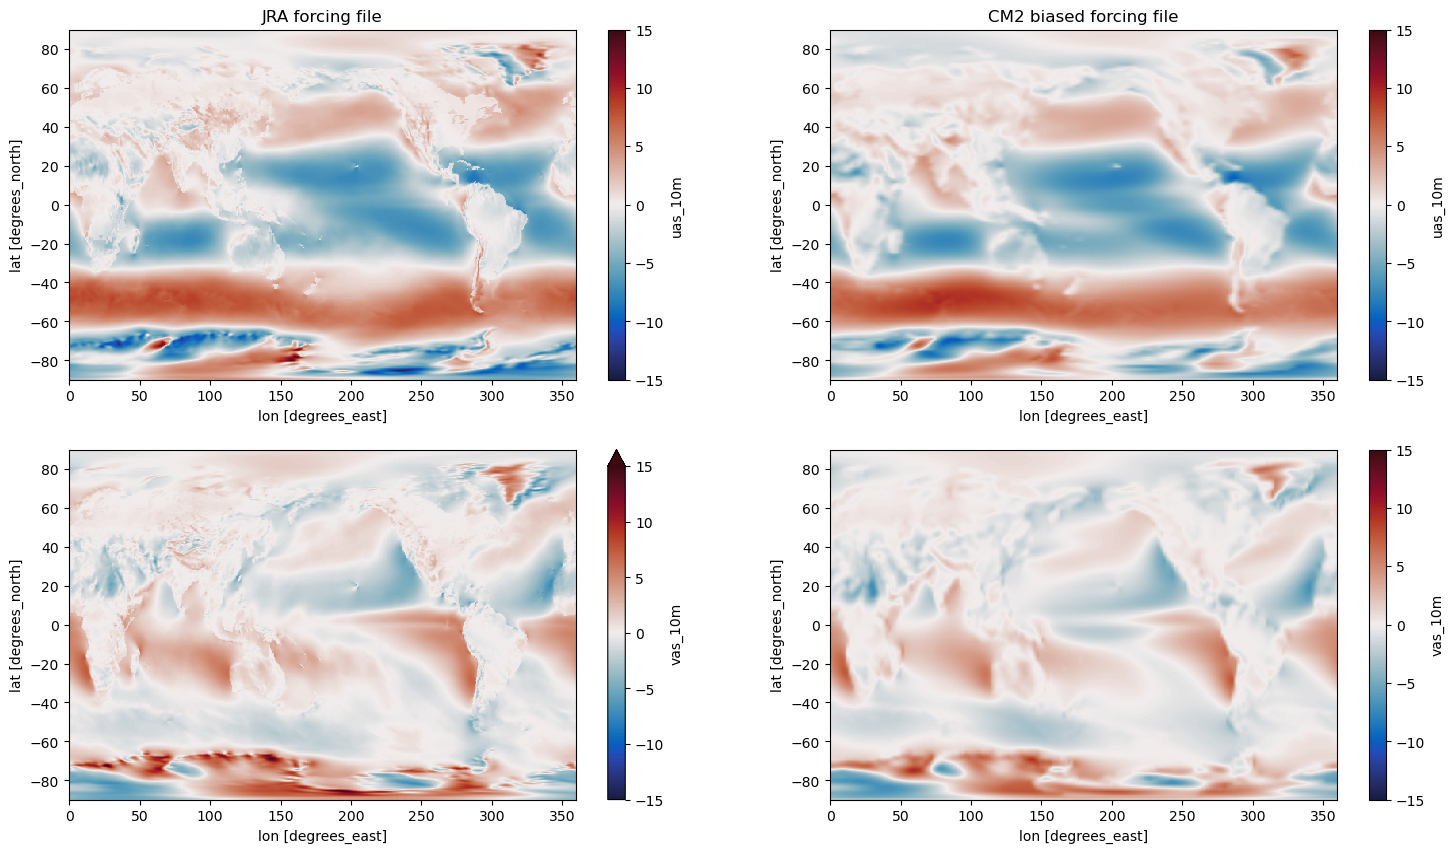

In [28]:
fig = plt.figure(figsize=(18,10))

plt.subplot(221)
u.mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.title('JRA forcing file')
plt.ylabel('u-wind')

plt.subplot(222)
u_global.mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.title('CM2 biased forcing file')

plt.subplot(223)
v.mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)
plt.ylabel('v-wind')

plt.subplot(224)
v_global.mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)

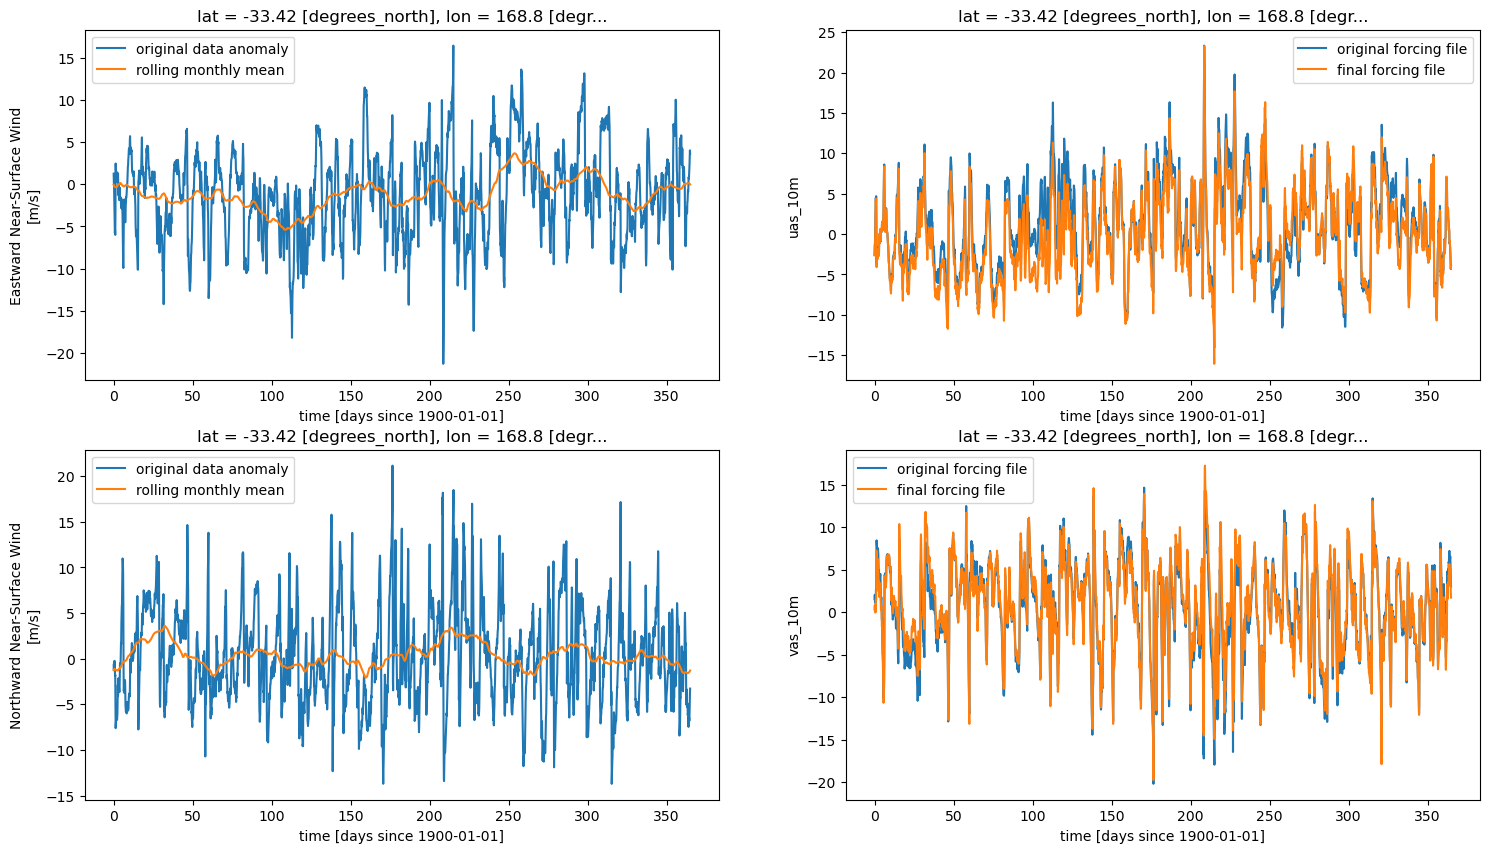

In [38]:
# check it looks sensible for sample location:

fig = plt.figure(figsize=(18,10))

plt.subplot(221)
u_difference[:,100,300].plot(label='original data anomaly')
u_monthly_mean[:,100,300].plot(label='rolling monthly mean')
#u_global[:,100,300].plot(label='bias')
plt.legend()

plt.subplot(222)
u[:,100,300].plot(label='original forcing file')
u_global[:,100,300].plot(label='final forcing file')
plt.legend()

plt.subplot(223)
v_difference[:,100,300].plot(label='original data anomaly')
v_monthly_mean[:,100,300].plot(label='rolling monthly mean')
#v_global[:,100,300].plot(label='bias')
plt.legend()

plt.subplot(224)
v[:,100,300].plot(label='original forcing file')
v_global[:,100,300].plot(label='final forcing file')
plt.legend()

## 6) Save new forcing file

### 6.1 Near Antarctic

In [59]:
# to ensure metadata etc is correct, copy old files and overwrite data:

# original files:
u_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.u_10.1990_1991.nc'
v_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.v_10.1990_1991.nc'

# new file names:
new_u_file = '/g/data/x77/wgh581/inputs/01deg_jra55v13_ryf9091_DSW_collaborative_project/RYF_with_CM2_025_bias.u_10.1990_1991.nc'
new_v_file = '/g/data/x77/wgh581/inputs/01deg_jra55v13_ryf9091_DSW_collaborative_project/RYF_with_CM2_025_bias.v_10.1990_1991.nc'

# copy old files into new file paths:
shutil.copyfile(u_file, new_u_file)
shutil.copyfile(v_file, new_v_file)

# then overwrite the variables in the new files with the new data:
ncFile = nc.Dataset(new_u_file,'r+')
ncFile.variables['uas_10m'][...] = u_new.values
ncFile.close()
ncFile = nc.Dataset(new_v_file,'r+')
ncFile.variables['vas_10m'][...] = v_new.values
ncFile.close()


### 6.2 Globally

In [39]:
# to ensure metadata etc is correct, copy old files and overwrite data:

# original files:
u_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.u_10.1990_1991.nc'
v_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.v_10.1990_1991.nc'

# new file names:
new_u_file = '/g/data/x77/wgh581/inputs/01deg_jra55v13_ryf9091_DSW_collaborative_project/RYF_with_CM2_025_bias_global.u_10.1990_1991.nc'
new_v_file = '/g/data/x77/wgh581/inputs/01deg_jra55v13_ryf9091_DSW_collaborative_project/RYF_with_CM2_025_bias_global.v_10.1990_1991.nc'

# copy old files into new file paths:
shutil.copyfile(u_file, new_u_file)
shutil.copyfile(v_file, new_v_file)

# then overwrite the variables in the new files with the new data:
ncFile = nc.Dataset(new_u_file,'r+')
ncFile.variables['uas_10m'][...] = u_global.values
ncFile.close()
ncFile = nc.Dataset(new_v_file,'r+')
ncFile.variables['vas_10m'][...] = v_global.values
ncFile.close()


---

In [60]:
# Test if new forcing file is correct

In [5]:
u_file_test = '/g/data/x77/wgh581/inputs/01deg_jra55v13_ryf9091_DSW_collaborative_project/RYF_with_CM2_025_bias.u_10.1990_1991.nc'
ds = xr.open_dataset(u_file_test, decode_times=False)
u_test = ds.uas_10m
u_test = u_test.load()

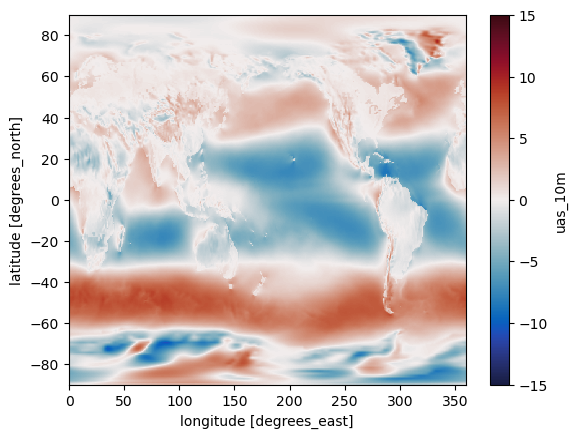

In [8]:
u_test.mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)

In [41]:
u_global_test = '/g/data/x77/wgh581/inputs/01deg_jra55v13_ryf9091_DSW_collaborative_project/RYF_with_CM2_025_bias_global.u_10.1990_1991.nc'
ds_global     = xr.open_dataset(u_global_test, decode_times=False)
u_global_test = ds_global.uas_10m
u_global_test = u_global_test.load()

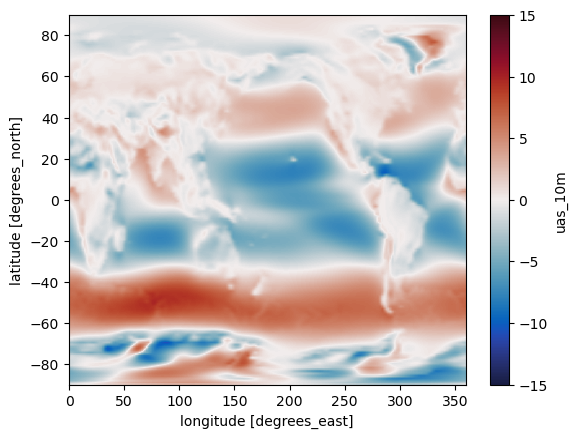

In [43]:
u_global_test.mean('time').plot(vmin=-15, vmax=15, cmap=cmocean.balance)